In [1]:
import glob
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, confusion_matrix

In [2]:
def tpr(tp, fn):
    if tp == 0 and fn == 0:
        return 0
    return tp / (tp + fn)


def tnr(tn, fp):
    if tn == 0 and fp == 0:
        return 0
    return tn / (tn + fp)


def ppv(tp, fp):
    if tp == 0 and fp == 0:
        return 0
    return tp / (tp + fp)


def fpr(fp, tn):
    if fp == 0 and fp == 0:
        return 0
    return fp / (fp + tn)


def balanced_acc(tpr, tnr):
    return (tpr + tnr) / 2


def f1(ppv, tpr):
    if ppv == 0 and tpr == 0:
        return 0
    return 2 * ppv * tpr / (ppv + tpr)


In [3]:
folds = glob.glob("folds/*")

for i, fold in enumerate(folds):
    with open(fold, "rb") as f:
        fold_dict = pkl.load(f)

    y_test = fold_dict["y_test"]

    if i == 0:
        global_target = y_test

    else:
        global_target = np.vstack((global_target,y_test))

global_target.shape

(47598, 1)

In [6]:
results_list = glob.glob("grid_results/sem_*")

print("numero de redes treinadas: ", len(results_list))

metrics_dict = {}
auc_list = {
    "index": [],
    "auc": [],
    "fit_time": [],
    "predict_time": [],
    "rmse_tx": [],
    "std_tx": [],
    "rmse_obt": [],
    "std_obt": [],
}

FPR_list = TPR_list = []

for i, file in enumerate(results_list):
    with open(file, "rb") as handle:
        result = pkl.load(handle)
        predicted = result["y_predict"]
        fit_time = result["fit_time"][0]
        predict_time = result["predict_time"][0]

    rse = ((predicted - global_target) ** 2) ** 0.5

    metrics_dict[i] = {
        "file_name": 0,
        "tp": [],
        "tn": [],
        "fp": [],
        "fn": [],
        "th": [],
        "tpr": [],
        "fpr": [],
        "tnr": [],
        "ppv": [],
        "bacc": [],
        "f1": [],
        "auc": 0,
        "rmse_tx": np.mean(rse[global_target == 1]),
        "std_tx": np.std(rse[global_target == 1]),
        "rmse_obt": np.mean(rse[global_target == 0]),
        "std_obt": np.std(rse[global_target == 0]),
    }

    metrics_dict[i]["file_name"] = file.split("/")[-1]

    threshold_eval = np.linspace(0, max(predicted), num=50)

    for thres in threshold_eval:
        predictions = np.zeros(predicted.shape)

        predictions[predicted > thres[0]] = 1

        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(predictions == 1, global_target == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(predictions == 0, global_target == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(predictions == 1, global_target == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(predictions == 0, global_target == 1))

        TPR = tpr(TP, FN)

        FPR = fpr(FP, TN)

        TNR = tnr(TN, FP)

        PPV = ppv(TP, FP)

        BACC = balanced_acc(TPR, TNR)

        F1 = f1(PPV, TPR)

        metrics_dict[i]["tp"].append(TP)
        metrics_dict[i]["tn"].append(TN)
        metrics_dict[i]["fp"].append(FP)
        metrics_dict[i]["fn"].append(FN)
        metrics_dict[i]["tpr"].append(TPR)
        metrics_dict[i]["fpr"].append(FPR)
        metrics_dict[i]["tnr"].append(TNR)
        metrics_dict[i]["ppv"].append(PPV)
        metrics_dict[i]["bacc"].append(BACC)
        metrics_dict[i]["f1"].append(F1)
        metrics_dict[i]["th"].append(thres[0])

    metrics_dict[i]["auc"] = auc(metrics_dict[i]["fpr"], metrics_dict[i]["tpr"])

    auc_list["index"].append(i)
    auc_list["auc"].append(metrics_dict[i]["auc"])
    auc_list["fit_time"].append(fit_time)
    auc_list["predict_time"].append(predict_time)
    auc_list["rmse_tx"].append(metrics_dict[i]["rmse_tx"])
    auc_list["std_tx"].append(metrics_dict[i]["std_tx"])
    auc_list["rmse_obt"].append(metrics_dict[i]["rmse_obt"])
    auc_list["std_obt"].append(metrics_dict[i]["std_obt"])


auc_df = pd.DataFrame(auc_list).sort_values(by=["auc"], ascending=False)

auc_df.head(10)

numero de redes treinadas:  5


,index,auc,fit_time,predict_time,rmse_tx,std_tx,rmse_obt,std_obt
4,4,0.691926,29.539844,0.318320,0.180381,0.109242,0.742721,0.109137
3,3,0.690345,42.961824,0.384466,0.181762,0.108032,0.742407,0.109045
2,2,0.690137,37.857813,0.280282,0.188719,0.087675,0.749487,0.089130
0,0,0.673508,87.558677,0.685771,0.190373,0.088540,0.752422,0.092693
1,1,0.000000,8.198166,0.298944,0.000000,0.000000,1.000000,0.000000


sem_tp_doador_layers_(3, 3, 3)__activation_function_sigmoid__output_function_linear__batch_300__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.6919261221966874


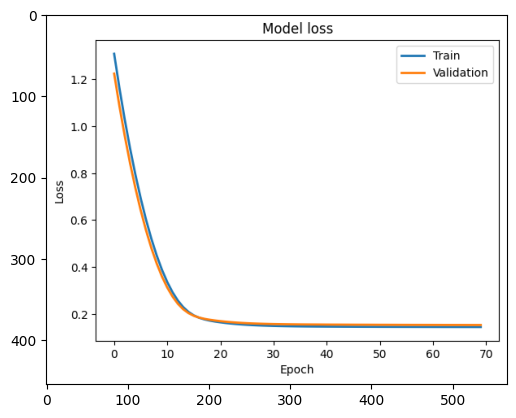

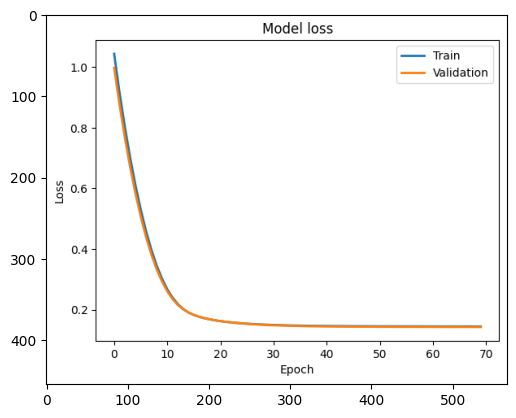

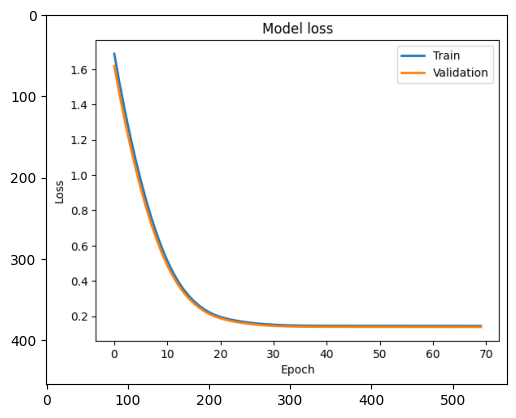

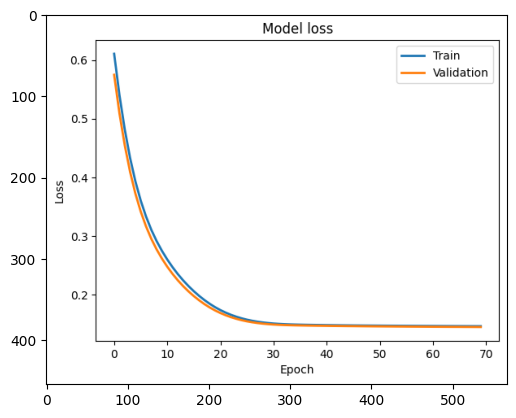

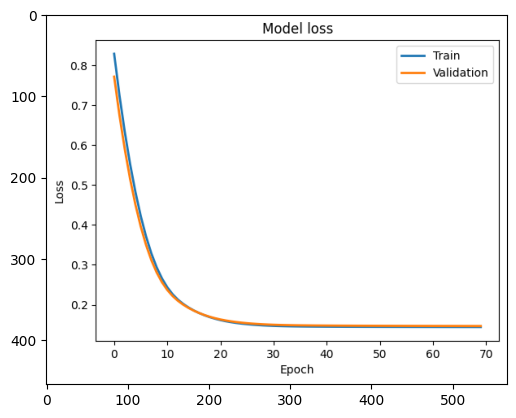

sem_tp_doador_layers_(3, 3, 3)__activation_function_sigmoid__output_function_relu__batch_300__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.6903450316849976


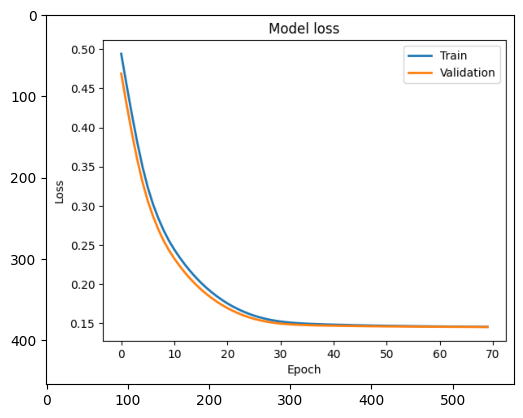

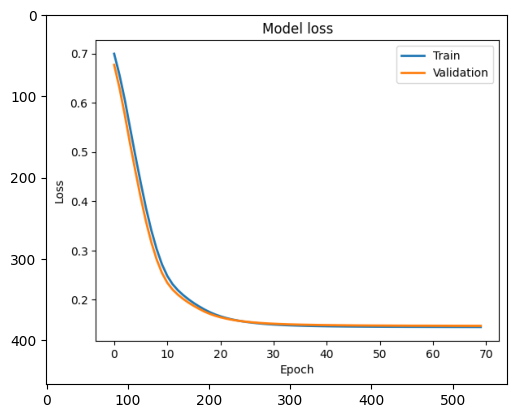

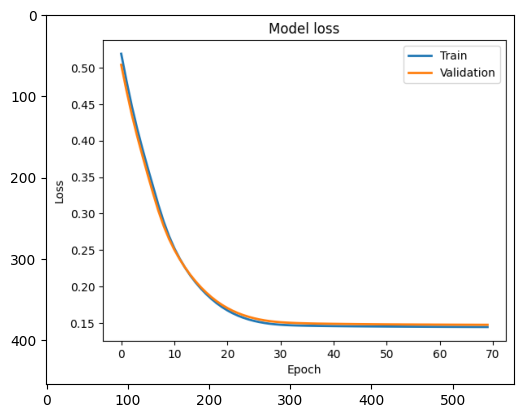

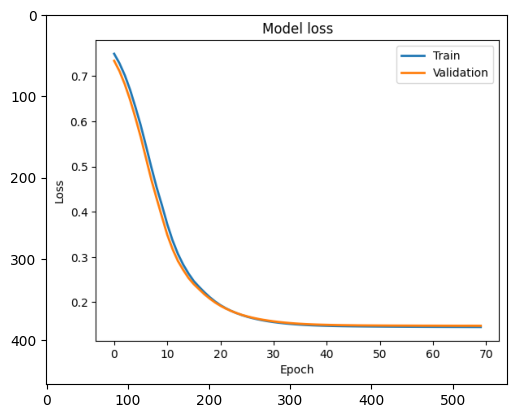

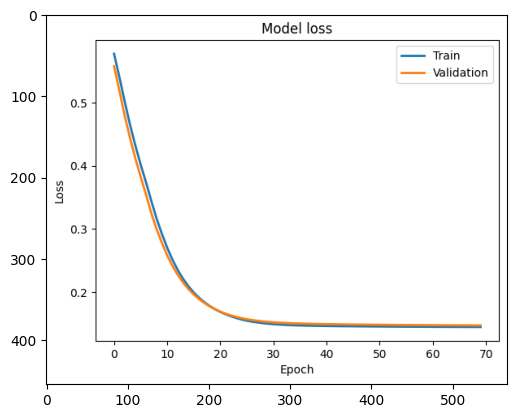

sem_tp_doador_layers_(3, 3, 3)__activation_function_sigmoid__output_function_sigmoid__batch_300__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.6901371594459969


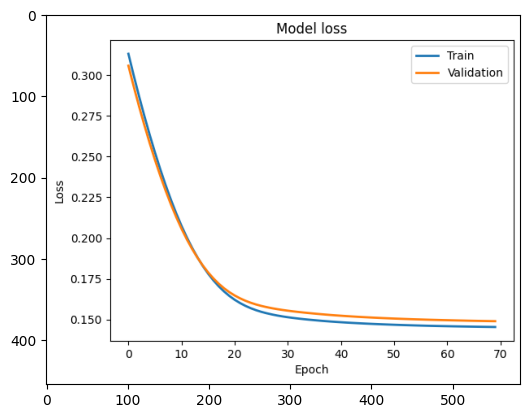

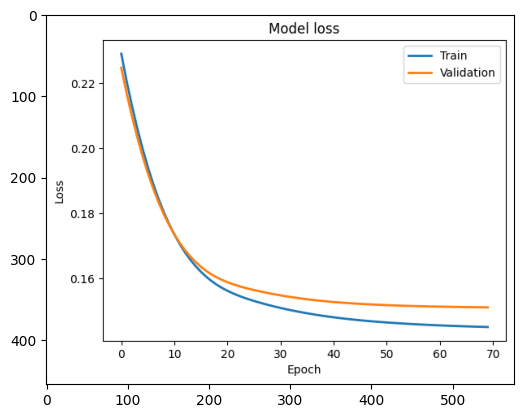

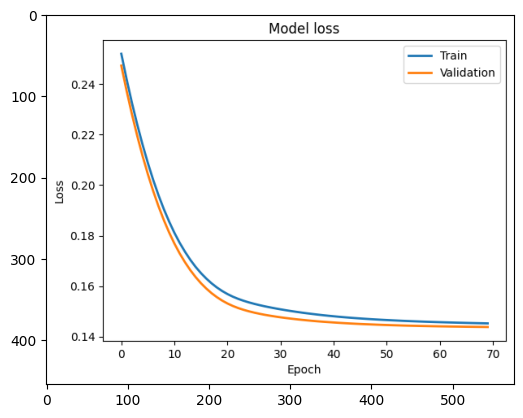

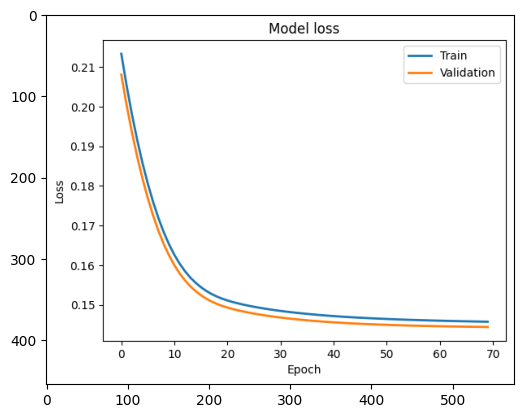

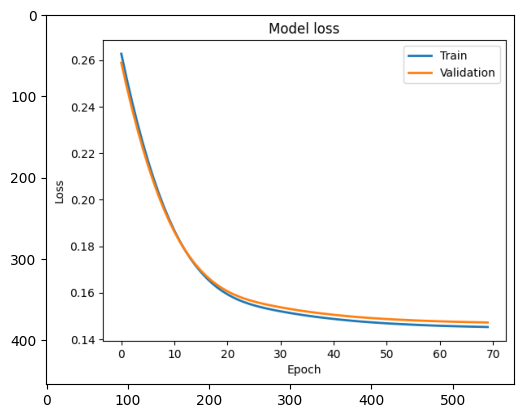

sem_tp_doador_layers_(3, 3, 3)__activation_function_relu__output_function_sigmoid__batch_300__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.6735083909860748


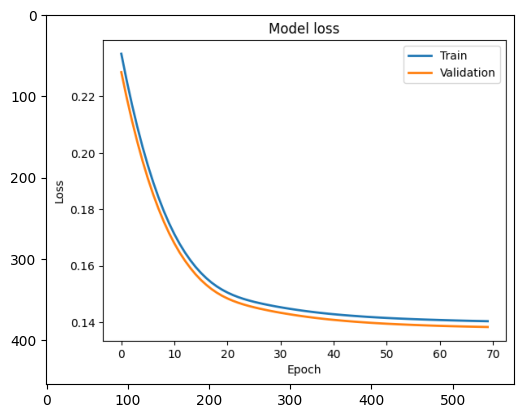

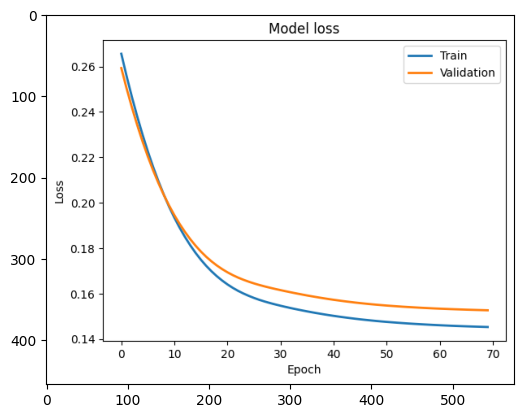

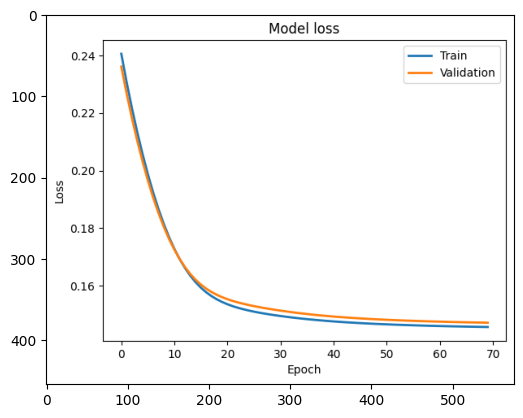

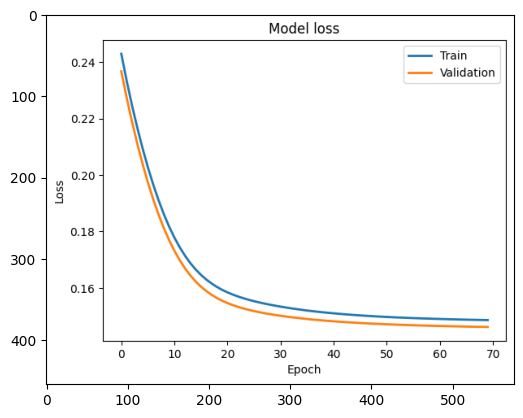

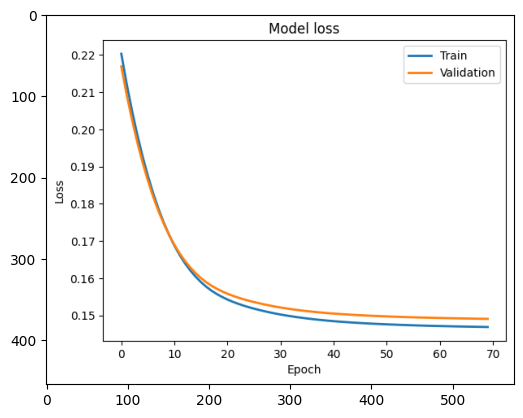

sem_tp_doador_layers_(3, 3, 3)__activation_function_sigmoid__output_function_softmax__batch_300__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.0


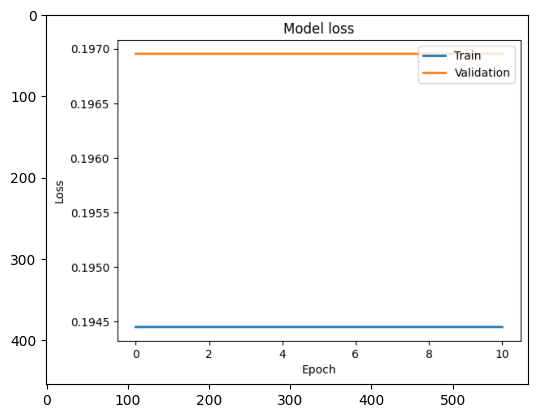

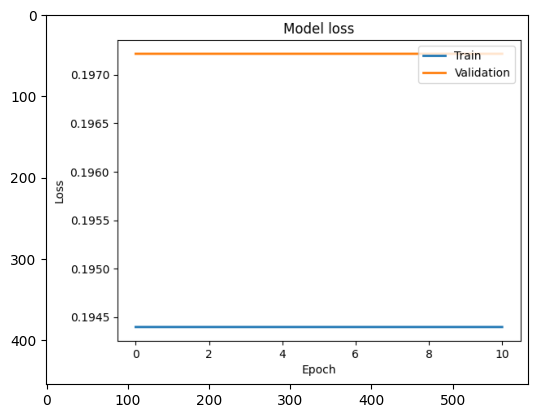

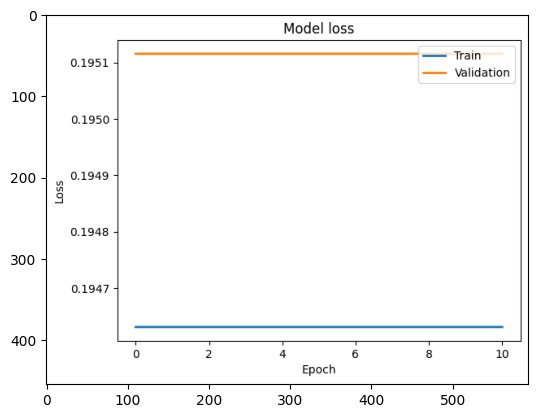

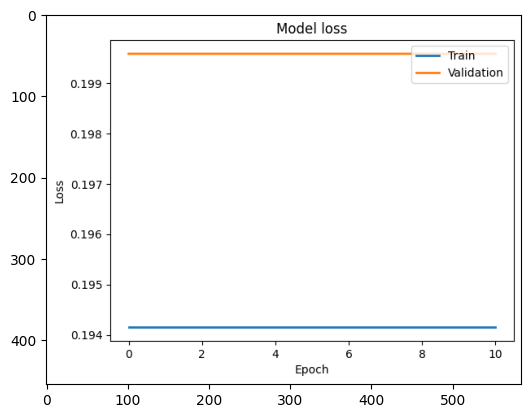

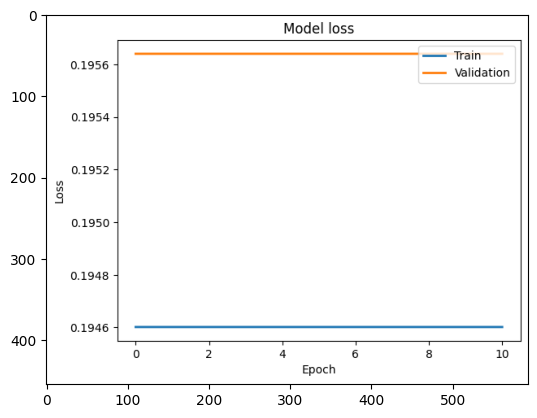

IndexError: index 5 is out of bounds for axis 0 with size 5

In [7]:
import matplotlib.image as mpimg

for i in range(10):
    index = auc_df.index[i]

    print(metrics_dict[index]["file_name"])
    print(metrics_dict[index]["auc"])
    
    for j in range(5):
        img = mpimg.imread(
            "learning_curves/"
            + "model-loss__"
            + metrics_dict[index]["file_name"]
            + "__fold_{}__.png".format(j)
        )
        imgplot = plt.imshow(img)
        plt.show()

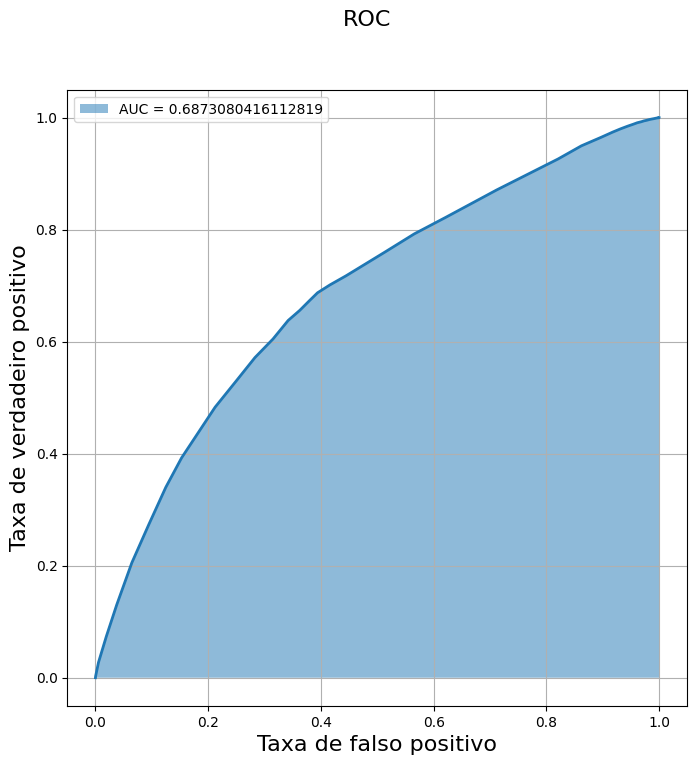

<Figure size 640x480 with 0 Axes>

In [10]:
scale = 1

width = height = 8

choice = 0

index = auc_df.index[choice]

best_nn_df = pd.DataFrame(metrics_dict[index])

fig = plt.figure(figsize=[scale * width, scale * height])
ax = fig.add_subplot(1, 1, 1)
fig.suptitle("ROC", fontsize=16)

ax.plot(
    best_nn_df.fpr,
    best_nn_df.tpr,
    linewidth=2,
)

ax.fill_between(
    best_nn_df.fpr,
    [0 for i in range(len(best_nn_df.fpr))],
    best_nn_df.tpr,
    alpha=0.5,
    label="AUC = {}".format(best_nn_df.auc.values[0]),
)

ax.set_ylabel("Taxa de verdadeiro positivo", fontsize=16)
ax.set_xlabel("Taxa de falso positivo", fontsize=16)

ax.legend()
ax.grid()

plt.show()

plt.savefig("figures/ROC.png")

In [11]:
best_nn_df = best_nn_df.sort_values(by=["tpr"],ascending=False)

best_nn_df[best_nn_df.fpr == 0].head(10)

,file_name,tp,tn,fp,fn,th,tpr,fpr,tnr,ppv,bacc,f1,auc
49,"sem_tp_doador_layers_(3, 3, 3)__activation_fun...",0,9267,0,38331,0.947456,0.0,0.0,1.0,0.0,0.5,0.0,0.687308


In [48]:
best_nn = best_nn_df[best_nn_df.fpr == 0].loc[41]
best_nn.file_name

'layers_(3, 3, 3)__activation_function_relu__output_function_sigmoid__batch_300__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl'

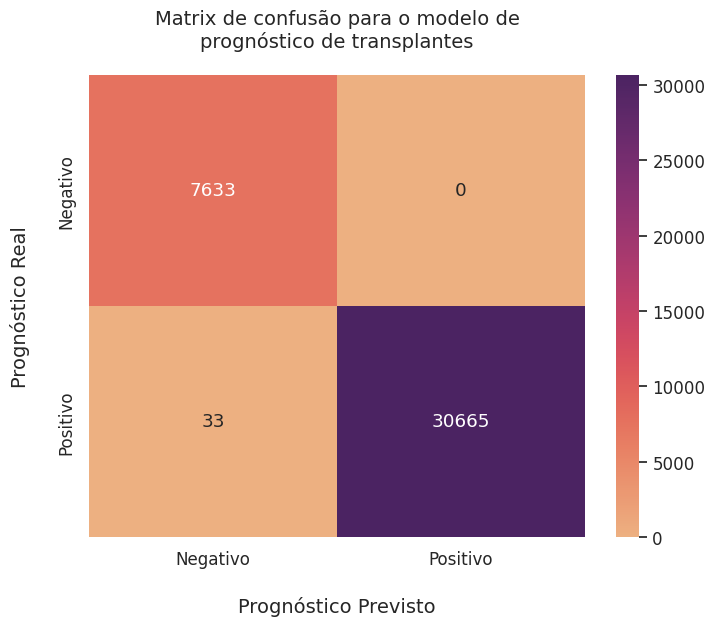

In [49]:
import seaborn as sns

# Mounting confusion Matrix

conf_matrix = np.array([[best_nn.tn, best_nn.fp], [best_nn.fn, best_nn.tp]],dtype=int)

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8, 6), dpi=100)
# Scale up the size of all text
sns.set(font_scale=1.1)

ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="flare"
)

# set x-axis label and ticks.
ax.set_xlabel("Prognóstico Previsto", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(["Negativo", "Positivo"])

# set y-axis label and ticks
ax.set_ylabel("Prognóstico Real", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(["Negativo", "Positivo"])

# set plot title
ax.set_title("Matrix de confusão para o modelo de\nprognóstico de transplantes", fontsize=14, pad=20)

plt.show()

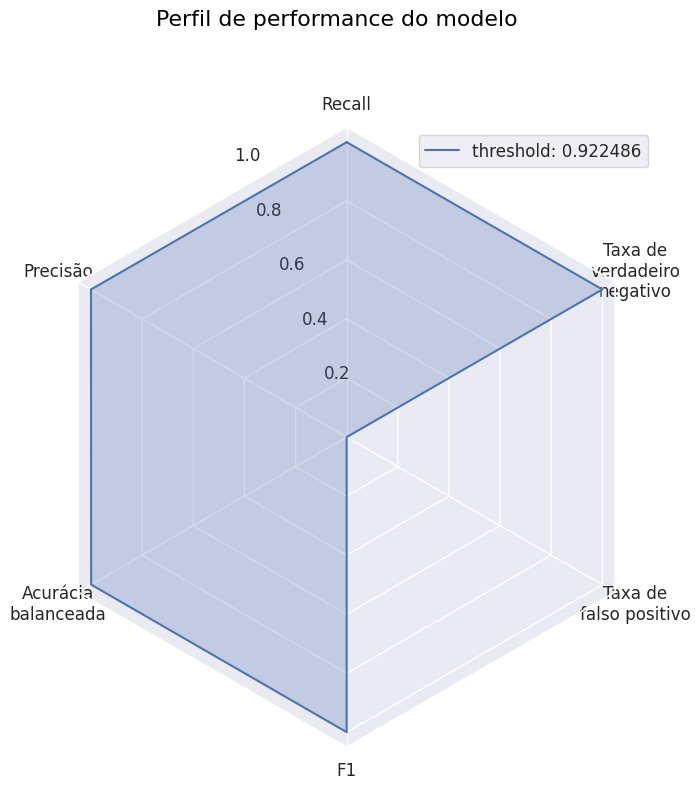

In [55]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame="circle"):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        name = "radar"
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location("N")

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == "circle":
                return Circle((0.5, 0.5), 0.5)
            elif frame == "polygon":
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == "circle":
                return super()._gen_axes_spines()
            elif frame == "polygon":
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self,
                    spine_type="circle",
                    path=Path.unit_regular_polygon(num_vars),
                )
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(
                    Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes
                )
                return {"polar": spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


N = 6
theta = radar_factory(N, frame="polygon")

spoke_labels = [
    "Recall",
    "Precisão",
    "Acurácia\nbalanceada",
    "F1",
    "Taxa de\nfalso positivo",
    "Taxa de\nverdadeiro\nnegativo",
]
metrics = [best_nn.tpr, best_nn.ppv, best_nn.bacc, best_nn.f1, best_nn.fpr, best_nn.tnr]

# fig, axs = plt.subplots(
#     figsize=(9, 9), nrows=1, ncols=1, subplot_kw=dict(projection="radar")
# )

fig = plt.figure(figsize=[scale * width, scale * height])
ax = fig.add_subplot(1, 1, 1, projection="radar")

fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

ax.plot(theta, metrics, label="threshold: {:.6f}".format(best_nn.th))
ax.fill(theta, metrics, alpha=0.25)
ax.set_varlabels(spoke_labels)

ax.legend()

fig.text(
    0.5,
    0.965,
    "Perfil de performance do modelo",
    horizontalalignment="center",
    color="black",
    size="large",
)

plt.show()